# HISEAS LIG SST Interpolation + Visualization
#### Anna Chen's Notebook
#### Updated on Feb 28, 2025

### Takes in data from the harmonized Hoffman et al. Excel spreadsheet and plots SSTs of each proxy type

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import geopandas as gpd
import geodatasets
import netCDF4

import xarray as xr
from scipy.interpolate import griddata

import warnings
# Filter out warnings from openpyxl regarding unknown extensions.
warnings.filterwarnings("ignore", message="Unknown extension is not supported and will be removed")
# Filter out pyproj warnings regarding converting masked elements to nan.
warnings.filterwarnings("ignore", message="Warning: converting a masked element to nan.")

In [2]:
# Open the Excel file and retrieve sheet names
excel_file = "SST_Hoffman_Harmonized_AC_ES_no_V28_238.xlsx"         # Changed on Dec 4, 2025
xls = pd.ExcelFile(excel_file)
sheet_names = xls.sheet_names

# List of sheet names to remove
sheets_to_remove = [
    "Reference Cores Tie Points",
    "Fig1 Global & Regional Stacks",
    "HadSST & SynTrACE Bias Estimate",
    "TEMPLATE",
    "NATL Data Read Me",
    "PAC Data Read Me",
    "IND Data Read Me",
    "SATL Data Read Me"
]

# Remove each sheet in sheets_to_remove if it exists in core_ID_list
for sheet in sheets_to_remove:
    if sheet in sheet_names:
        sheet_names.remove(sheet)

print("List of tabs with data in the Excel file:")
print(sheet_names)

List of tabs with data in the Excel file:
['M23323-1_UK37', 'M23323-1_Foram', 'V28-14', 'EW9302-JPC8', 'ODP 980', 'NA87-25', 'V27-20', 'M23414-9', 'NEAP18k', 'V23-82', 'K708-1', 'MD04-2845', 'V29-179', 'SU92-03', 'D-117', 'CH69-K09', 'V30-97', 'MD95-2040_UK37', 'MD95-2040_Foram', 'SU90-03', 'MD01-2444_UK37', 'MD01-2444_MgCa', 'MD95-2036', 'KNR140-37JPC', 'MD02-2575', 'GIK15637-1', 'M12392-1', 'TR126-29', 'TR126-23', 'M35027-1', 'V22-196', 'V28-127', 'MD03-2707', 'V25-59', 'Y7211-1', 'ODP1020', 'ODP1018', 'MD01-2421', 'ODP893', 'ODP1014A', 'ODP1012', 'LAPAZ21', 'ODP1145', 'ODP1146', 'MD97-2151', 'GIK17961-2', 'W8402A', 'TR163-22', 'ODP846', 'V19-29', 'Y71-6-12', 'MD06-3018', 'MD97-2121', 'RC15-61', 'ODP1123', 'MD97-2106', 'DSDP594', 'MD97-2120', 'Y9', 'MD97-2108', 'MD97-2109', 'V34-88', 'RC12-339', 'GeoB10038-4_MgCa', 'GeoB10038-4_UK37', 'MD01-2378', 'V28-345', 'MD94-101', 'MD84-527', 'MD94-102', 'MD73-25', 'MD88-770_Diatom', 'MD88-770_Foram', 'MD02-2488', 'V22-182_Foram', 'V22-182_Cocc

In [3]:
# Define proxy marker mapping
proxy_marker_map = {
    "Foram": "o",      # Circle
    "UK37": "^",       # Triangle
    "MgCa": "s",       # Square
    "Radiolaria": "D", # Diamond
    "Cocc": "P",       # Plus
    "Diatom": "X"      # Filled-X
}

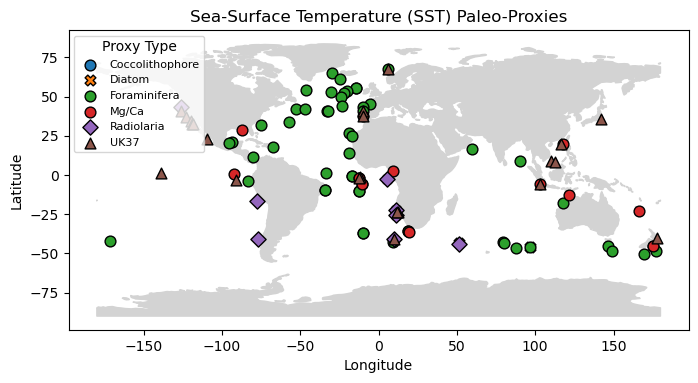

The data frame of records 127000 yr BP is:
              ID  Longitude  Latitude            Proxy        SST    SST+2sd  \
0       M23323-1       5.92     67.77             UK37   0.390805  11.002641   
1       M23323-1       5.92     67.77     Foraminifera   7.292697  12.349014   
2         V28-14     -29.57     64.78     Foraminifera   3.846172  11.966761   
3    EW9302-JPC8     -25.00     61.42     Foraminifera   7.970303  16.595263   
4        ODP 980     -14.70     55.48     Foraminifera   7.725748  17.785723   
..           ...        ...       ...              ...        ...        ...   
98      RC12-294     -10.10    -37.27     Foraminifera  13.521733  20.326317   
99      RC12-294     -10.10    -37.27  Coccolithophore  14.277649  21.052428   
100     ODP 1089       9.90    -40.93             UK37  21.538471  25.186099   
101     ODP 1089       9.90    -40.93       Radiolaria  13.698007  19.209782   
102     PS2489-2       8.97    -42.90     Foraminifera   6.975720  13.297537 

In [ ]:
# NEW proxy map code (Updated on Dec 4, 2025)

def extract_record_for_sheet(sheet, year_input):
    """
    For a given sheet name and year:
      - Reads columns B, C, D (Longitude, Latitude, Proxy) and extracts row 2 (first data row).
      - Reads columns Q and S (Age and SST Mean), finds the row where Age matches the given year,
        and extracts the SST Mean.
      - Returns a dictionary with keys: "Longitude", "Latitude", "Proxy", and "SST".
      - If no matching year is found, returns None.
    """
    try:
        # Read base info (columns B, C, D) from row 2 only.
        df_base = pd.read_excel(excel_file, sheet_name=sheet, usecols="A,B,C,D")
        df_base.columns = ['ID', 'Longitude', 'Latitude', 'Proxy']
        # Row 2 is the first data row (index 0)
        ID = df_base.iloc[0]['ID']
        lon = df_base.iloc[0]['Longitude']
        lat = df_base.iloc[0]['Latitude']
        proxy = df_base.iloc[0]['Proxy']
        if proxy == "MgCa":
            proxy = "Mg/Ca"
        if proxy == "Cocc":
            proxy = "Coccolithophore"
        if proxy == "Foram":
            proxy = "Foraminifera"
    except Exception as e:
        print(f"Error reading base info from sheet {sheet}: {e}")
        return None

    try:
        # Read age and SST info (columns Q and S) for all rows.
        df_sst = pd.read_excel(excel_file, sheet_name=sheet, usecols="R,T,S,U")
        df_sst.columns = ['Age', 'SST', 'SST-2sd', 'SST+2sd']
        # Find the row where Age matches the entered year.
        match = df_sst[df_sst['Age'] == year_input]
        if match.empty:
            print(f"Year {year_input} not found in sheet {sheet}.")
            return None
        # Extract the SST value from the first matching row.
        sst_val = match.iloc[0]['SST']
        sst_upper_val = match.iloc[0]['SST+2sd']
        sst_lower_val = match.iloc[0]['SST-2sd']
    except Exception as e:
        print(f"Error reading SST info from sheet {sheet}: {e}")
        return None

    return {"ID": ID, "Longitude": lon, "Latitude": lat, "Proxy": proxy,
            "SST": sst_val, "SST+2sd": sst_upper_val, "SST-2sd": sst_lower_val}

def build_gdf(year_input):
    """
    Loop through all sheets, extract records for the given year, and return a DataFrame.
    """
    records = []
    for sheet in sheet_names:
        rec = extract_record_for_sheet(sheet, year_input)
        if rec is not None:
            records.append(rec)
    if records:
        return pd.DataFrame(records)
    else:
        return pd.DataFrame()

def plot_proxy_data(gdf):
    """
    Plots the data grouped by proxy type onto a world map.
    """

    # Load world map from geodatasets via GeoPandas.
    world = gpd.read_file(geodatasets.data.naturalearth.land['url'])

    # Create the plot.
    fig, ax = plt.subplots(figsize=(8, 4))
    world.plot(ax=ax, color='lightgrey', edgecolor='lightgrey')

    # Group the data by proxy type and plot each group.
    for proxy, group in gdf.groupby("Proxy"):
        ax.scatter(
            group['Longitude'], group['Latitude'],
            marker=proxy_marker_map.get(proxy, "o"),
            edgecolor="black", s=60,
            label=proxy
        )

    # Add legend for proxy types.
    ax.legend(title="Proxy Type", loc='upper left', prop={'size': 8})
    plt.title("Sea-Surface Temperature (SST) Paleo-Proxies")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

if __name__ == "__main__":
    try:
        year_input = int(input("Enter a specific year before present (e.g., 115000): "))
    except ValueError:
        print("Invalid year input.")
        exit()

    # Build the DataFrame of records.
    gdf = build_gdf(year_input)
    if gdf.empty:
        print("No records found for the given year.")
    else:
        # Plot the data grouped by proxy type.
        plot_proxy_data(gdf)

    # Print the DataFrame of records.
    print(f"The data frame of records {year_input} yr BP is:")
    print(gdf)

Enter a specific year before present (e.g., 115000):  127000


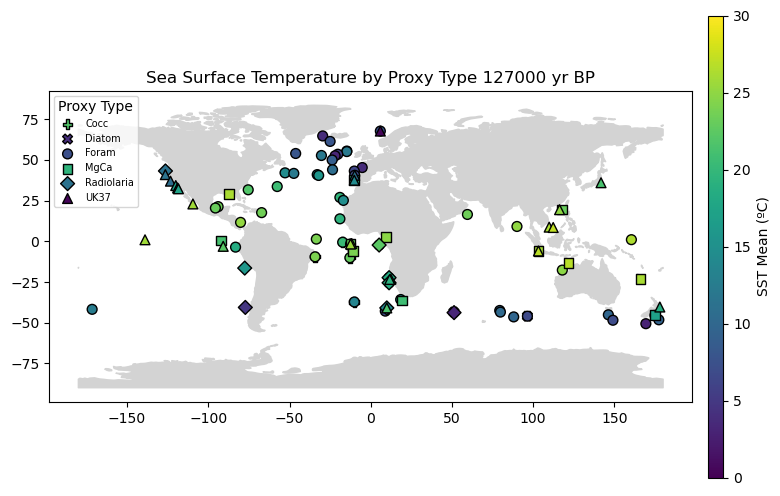

The data frame of records 127000 yr BP is:
              ID  Longitude  Latitude       Proxy        SST    SST+2sd  \
0       M23323-1       5.92     67.77        UK37   0.390805  11.002641   
1       M23323-1       5.92     67.77       Foram   7.292697  12.349014   
2         V28-14     -29.57     64.78       Foram   3.846172  11.966761   
3    EW9302-JCP8     -25.00     61.42       Foram   7.970303  16.595263   
4        ODP 980     -14.70     55.48       Foram   7.725748  17.785723   
..           ...        ...       ...         ...        ...        ...   
99      RC12-294     -10.10    -37.27       Foram  13.521733  20.326317   
100     RC12-294     -10.10    -37.27        Cocc  14.277649  21.052428   
101     ODP 1089       9.90    -40.93        UK37  21.538471  25.186099   
102     ODP 1089       9.90    -40.93  Radiolaria  13.698007  19.209782   
103     PS2489-2       8.97    -42.90       Foram   6.975720  13.297537   

       SST-2sd  
0     3.981187  
1     9.717605  
2    

In [ ]:
# OLD make map


def extract_record_for_sheet(sheet, year_input):
    """
    For a given sheet name and year:
      - Reads columns B, C, D (Longitude, Latitude, Proxy) and extracts row 2 (first data row).
      - Reads columns Q and S (Age and SST Mean), finds the row where Age matches the given year,
        and extracts the SST Mean.
      - Returns a dictionary with keys: "Longitude", "Latitude", "Proxy", and "SST".
      - If no matching year is found, returns None.
    """
    try:
        # Read base info (columns B, C, D) from row 2 only.
        df_base = pd.read_excel(excel_file, sheet_name=sheet, usecols="A,B,C,D")
        df_base.columns = ['ID', 'Longitude', 'Latitude', 'Proxy']
        # Row 2 is the first data row (index 0)
        ID = df_base.iloc[0]['ID']
        lon = df_base.iloc[0]['Longitude']
        lat = df_base.iloc[0]['Latitude']
        proxy = df_base.iloc[0]['Proxy']
    except Exception as e:
        print(f"Error reading base info from sheet {sheet}: {e}")
        return None

    try:
        # Read age and SST info (columns Q and S) for all rows.
        df_sst = pd.read_excel(excel_file, sheet_name=sheet, usecols="R,T,S,U")
        df_sst.columns = ['Age', 'SST', 'SST-2sd', 'SST+2sd']
        # Find the row where Age matches the entered year.
        match = df_sst[df_sst['Age'] == year_input]
        if match.empty:
            print(f"Year {year_input} not found in sheet {sheet}.")
            return None
        # Extract the SST value from the first matching row.
        sst_val = match.iloc[0]['SST']
        sst_upper_val = match.iloc[0]['SST+2sd']
        sst_lower_val = match.iloc[0]['SST-2sd']
    except Exception as e:
        print(f"Error reading SST info from sheet {sheet}: {e}")
        return None

    return {"ID": ID, "Longitude": lon, "Latitude": lat, "Proxy": proxy,
            "SST": sst_val, "SST+2sd": sst_upper_val, "SST-2sd": sst_lower_val}

def build_gdf(year_input):
    """
    Loop through all sheets, extract records for the given year, and return a DataFrame.
    """
    records = []
    for sheet in sheet_names:
        rec = extract_record_for_sheet(sheet, year_input)
        if rec is not None:
            records.append(rec)
    if records:
        return pd.DataFrame(records)
    else:
        return pd.DataFrame()

def plot_proxy_data(gdf):
    """
    Plots the data grouped by proxy type onto a world map.
    """
    # Set up colormap and fixed normalization from 5 to 30 ºC.
    cmap = plt.cm.viridis
    norm = colors.Normalize(vmin=0, vmax=30)

    # Load world map from geodatasets via GeoPandas.
    world = gpd.read_file(geodatasets.data.naturalearth.land['url'])

    # Create the plot.
    fig, ax = plt.subplots(figsize=(10, 6))
    world.plot(ax=ax, color='lightgrey', edgecolor='lightgrey')

    # Group the data by proxy type and plot each group.
    for proxy, group in gdf.groupby("Proxy"):
        ax.scatter(
            group['Longitude'], group['Latitude'],
            marker=proxy_marker_map.get(proxy, "o"),
            c=group['SST'],
            cmap=cmap, norm=norm,
            edgecolor="black", s=50,
            label=proxy
        )

    # Add a colorbar for SST values.
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02, aspect=30)
    cbar.set_label("SST Mean (ºC)")

    # Add legend for proxy types.
    ax.legend(title="Proxy Type", loc='upper left', prop={'size': 7})
    plt.title(f"Sea Surface Temperature by Proxy Type {year_input} yr BP")
    plt.show()

if __name__ == "__main__":
    try:
        year_input = int(input("Enter a specific year before present (e.g., 115000): "))
    except ValueError:
        print("Invalid year input.")
        exit()

    # Build the DataFrame of records.
    gdf = build_gdf(year_input)
    if gdf.empty:
        print("No records found for the given year.")
    else:
        # Plot the data grouped by proxy type.
        plot_proxy_data(gdf)

    # Print the DataFrame of records.
    print(f"The data frame of records {year_input} yr BP is:")
    print(gdf)

## Data Visualization and Model Building of Modern SST: HadISST v1.1 1981-2010
## Updated 4/10

#### Data access: https://www.metoffice.gov.uk/hadobs/hadisst/data/download.html
#### Citation: Rayner, N. A.; Parker, D. E.; Horton, E. B.; Folland, C. K.; Alexander, L. V.; Rowell, D. P.; Kent, E. C.; Kaplan, A. (2003) Global analyses of sea surface temperature, sea ice, and night marine air temperature since the late nineteenth century J. Geophys. Res.Vol. 108, No. D14, 4407 10.1029/2002JD002670

#### Hoffman et al. 2017

In [ ]:
# Load the Excel file as we did previously
excel_file = "SST_Hoffman_Harmonized_AC_ES.xlsx"
xls = pd.ExcelFile(excel_file)

# List of sheet names to remove
sheets_to_remove = [
    "Reference Cores Tie Points",
    "Fig1 Global & Regional Stacks",
    "HadSST & SynTrACE Bias Estimate",
    "TEMPLATE",
    "NATL Data Read Me",
    "PAC Data Read Me",
    "IND Data Read Me",
    "SATL Data Read Me"
]

# Initialize a list to hold (longitude, latitude) tuples.
lon_lat = []

# Loop through every sheet, but only process if not in sheets_to_remove.
for sheet in xls.sheet_names:
    if sheet in sheets_to_remove:
        continue  # Skip sheets in the remove list

    try:
        # Read only columns B and C from the first two rows.
        # Note: Excel row 2 corresponds to index 1 in pandas.
        df_sheet = pd.read_excel(excel_file, sheet_name=sheet, header=None, usecols="B:C", nrows=2)

        # Ensure that there are at least two rows in the sheet.
        if df_sheet.shape[0] < 2:
            continue

        # Extract longitude from cell B2 and latitude from cell C2.
        lon = df_sheet.iloc[1, 0]
        lat = df_sheet.iloc[1, 1]

        # Try converting the values to float; if conversion fails, skip this sheet.
        try:
            lon_val = float(lon)
            lat_val = float(lat)
            lon_lat.append((lon_val, lat_val))
        except (ValueError, TypeError):
            continue  # Skip if conversion to float fails
    except Exception as e:
        print(f"Error processing sheet '{sheet}': {e}")

# Create a DataFrame from the list of tuples.
df_coords = pd.DataFrame(lon_lat, columns=["Longitude", "Latitude"])

# Remove rows that contain any NaN values and any duplicated rows.
df_coords = df_coords.dropna().drop_duplicates().reset_index(drop=True)

# Optionally, display all rows in the DataFrame.
pd.set_option('display.max_rows', None)
print(df_coords)

    Longitude  Latitude
0        5.92     67.77
1      -29.57     64.78
2      -25.00     61.42
3      -14.70     55.48
4      -14.73     55.18
5      -46.20     54.00
6      -20.29     53.53
7      -30.35     52.76
8      -21.93     52.58
9      -23.74     50.00
10      -5.22     45.35
11     -23.51     44.00
12     -10.11     43.20
13     -52.75     42.10
14     -47.35     41.76
15     -32.93     41.00
16      -9.86     40.58
17     -32.05     40.50
18     -10.13     37.57
19     -57.57     33.68
20     -75.42     31.68
21     -87.11     29.00
22     -18.98     27.00
23     -16.85     25.16
24     -93.95     21.33
25     -95.62     20.48
26     -67.17     17.64
27     -18.97     13.83
28     -80.13     11.65
29       9.39      2.50
30     -33.48      1.37
31    -126.38     43.25
32    -126.43     41.00
33    -123.27     36.99
34     141.78     36.02
35    -120.03     34.28
36    -118.90     32.80
37    -118.38     32.28
38    -109.47     22.98
39     117.63     19.53
40     116.27   

In [ ]:
# Round the lon-lat data frame to its nearest 0.5º

# Create a copy of the original DataFrame
df_coords_round = df_coords.copy()

# Function to round a number to the nearest 0.5
round_half = lambda x: np.round(x * 2) / 2

# Apply rounding to each column
df_coords_round['Longitude'] = df_coords_round['Longitude'].apply(round_half)
df_coords_round['Latitude'] = df_coords_round['Latitude'].apply(round_half)

# Clip the rounded values to the allowed ranges
df_coords_round['Longitude'] = df_coords_round['Longitude'].clip(lower=-179.5, upper=179.5)
df_coords_round['Latitude'] = df_coords_round['Latitude'].clip(lower=-89.5, upper=89.5)

# Display the new DataFrame
print(df_coords_round)

    Longitude  Latitude
0         6.0      68.0
1       -29.5      65.0
2       -25.0      61.5
3       -14.5      55.5
4       -14.5      55.0
5       -46.0      54.0
6       -20.5      53.5
7       -30.5      53.0
8       -22.0      52.5
9       -23.5      50.0
10       -5.0      45.5
11      -23.5      44.0
12      -10.0      43.0
13      -53.0      42.0
14      -47.5      42.0
15      -33.0      41.0
16      -10.0      40.5
17      -32.0      40.5
18      -10.0      37.5
19      -57.5      33.5
20      -75.5      31.5
21      -87.0      29.0
22      -19.0      27.0
23      -17.0      25.0
24      -94.0      21.5
25      -95.5      20.5
26      -67.0      17.5
27      -19.0      14.0
28      -80.0      11.5
29        9.5       2.5
30      -33.5       1.5
31     -126.5      43.0
32     -126.5      41.0
33     -123.5      37.0
34      142.0      36.0
35     -120.0      34.5
36     -119.0      33.0
37     -118.5      32.5
38     -109.5      23.0
39      117.5      19.5
40      116.5   

In [ ]:
# Randomly sample 70 rows for training set from df_coords_round.
df_training = df_coords_round.sample(n=70, random_state=42)

# The remaining rows (those not in the training sample) become the testing set.
df_testing = df_coords_round.drop(df_training.index)

# Optionally, reset the indices of both DataFrames.
df_training = df_training.reset_index(drop=True)
df_testing = df_testing.reset_index(drop=True)

# Display the sizes of the resulting DataFrames.
print("Training set shape:", df_training.shape)
print("Testing set shape:", df_testing.shape)

Training set shape: (70, 2)
Testing set shape: (16, 2)


#### HadISST v1.1

In [ ]:
# Load netCDF dataset
HadISST = xr.open_dataset('HadISST_sst.nc')

# Clamp SST values: only keep values that are greater than -10.
# Values that are not greater than -10 are replaced with NaN.
HadISST_clamped = HadISST.where(HadISST.sst > -10)

# Override the original dataset with the clamped version.
HadISST = HadISST_clamped

# Remove the last time layer (January 2025)
HadISST = HadISST.isel(time=slice(0, -1))

# Verify the time range (optional)
print("Time range:", HadISST.time.min().values, "to", HadISST.time.max().values)

# Group the monthly SST data by the year component of the time coordinate, then average over the time dimension.
# This computes the mean of available months for each year.
HadISST_annual = HadISST.sst.groupby('time.year').mean('time', skipna=True)

# Optionally, convert the resulting DataArray to a Dataset with the variable name 'annual_sst'
HadISST_annual_ds = HadISST_annual.to_dataset(name='annual_sst')

# Check the resulting dataset
print(HadISST_annual_ds)

Time range: 1870-01-16T11:59:59.505615234 to 2024-12-16T12:00:00.000000000
<xarray.Dataset>
Dimensions:     (latitude: 180, longitude: 360, year: 155)
Coordinates:
  * latitude    (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude   (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * year        (year) int64 1870 1871 1872 1873 1874 ... 2021 2022 2023 2024
Data variables:
    annual_sst  (year, latitude, longitude) float32 -1.8 -1.8 -1.8 ... nan nan


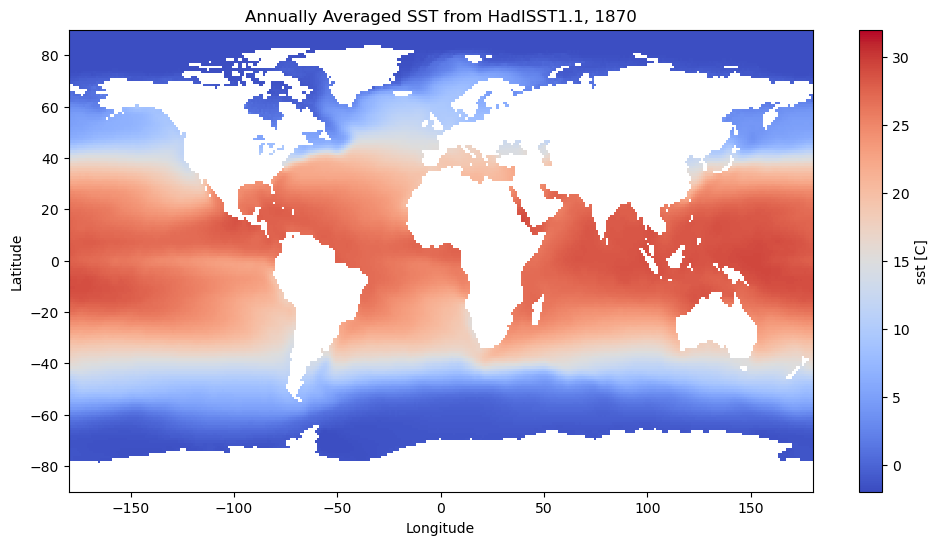

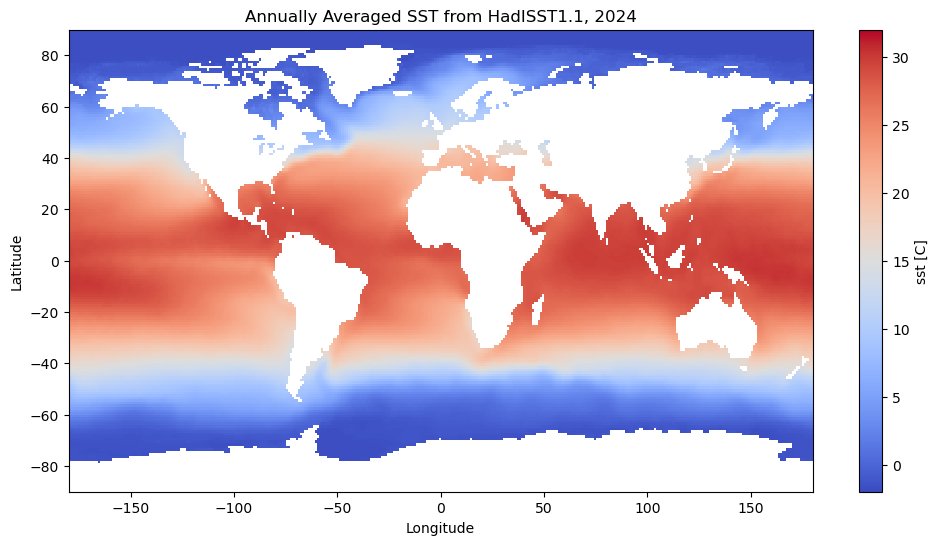

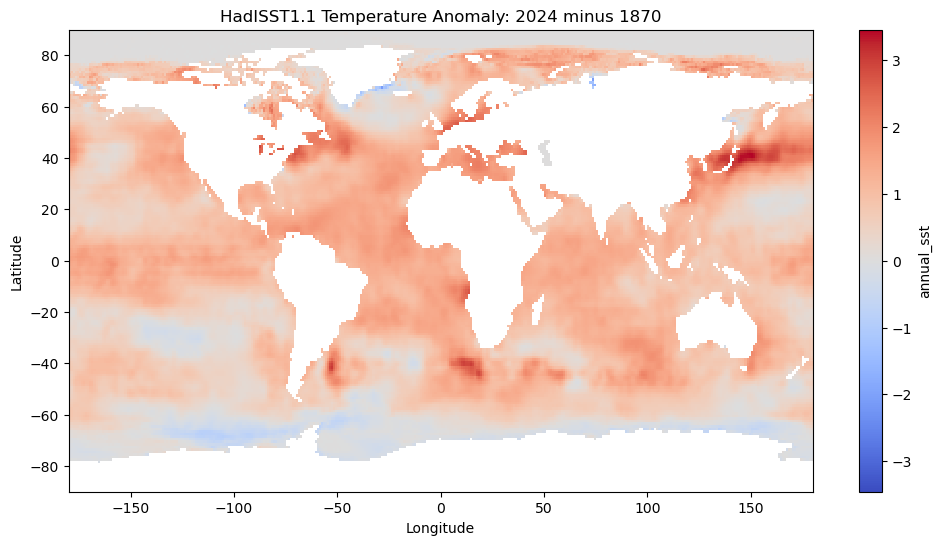

In [ ]:
# Plot the first year (1870) and the last year (2024)

# Plot the first year's SST with a colorbar from -2ºC to 32ºC.
fig, ax = plt.subplots(figsize=(12, 6))
HadISST_annual_ds.annual_sst.sel(year=1870).plot(
    ax=ax,
    vmin=-2,
    vmax=32,
    cmap='coolwarm',
    add_colorbar=True
)
ax.set_title(f"Annually Averaged SST from HadISST1.1, {first_year}")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Plot the last year's SST with a colorbar from -2ºC to 32ºC.
fig, ax = plt.subplots(figsize=(12, 6))
HadISST_annual_ds.annual_sst.sel(year=2024).plot(
    ax=ax,
    vmin=-2,
    vmax=32,
    cmap='coolwarm',
    add_colorbar=True
)
ax.set_title(f"Annually Averaged SST from HadISST1.1, {last_year}")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Select the first (1870) and last (2024) annual SST layers
sst_1870 = HadISST_annual_ds.annual_sst.sel(year=1870)
sst_2024 = HadISST_annual_ds.annual_sst.sel(year=2024)

# Compute the SST anomaly: difference between 2024 and 1870
sst_anomaly = sst_2024 - sst_1870

# Plot the SST anomaly using the coolwarm colormap
fig, ax = plt.subplots(figsize=(12, 6))
sst_anomaly.plot(
    ax=ax,
    cmap='coolwarm',
    add_colorbar=True
)
ax.set_title("HadISST1.1 Temperature Anomaly: 2024 minus 1870")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [ ]:
# Machine learning tools:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

##### 1. DATA PREPARATION #####

# Load the netCDF dataset
HadISST = xr.open_dataset('HadISST_sst.nc')

# Clamp SST values: keep only values greater than -10 (others become NaN)
HadISST_clamped = HadISST.where(HadISST.sst > -10)
HadISST = HadISST_clamped

# Remove the last time layer (January 2025)
HadISST = HadISST.isel(time=slice(0, -1))
print("Time range:", HadISST.time.min().values, "to", HadISST.time.max().values)

# Compute annual averages from monthly data
HadISST_annual = HadISST.sst.groupby('time.year').mean('time', skipna=True)
# Convert to a Dataset with variable name 'sst'
HadISST_annual_ds = HadISST_annual.to_dataset(name='sst')
print(HadISST_annual_ds)

# Convert the full annual dataset to a DataFrame.
# This DataFrame will have columns: year, latitude, longitude, and sst.
df_global = HadISST_annual_ds.sst.to_dataframe().reset_index()

# --- Ensure coordinate matching ---
# Round coordinates in the global dataset to one decimal.
df_global['latitude']  = df_global['latitude'].round(1)
df_global['longitude'] = df_global['longitude'].round(1)

# Ensure the fixed grid DataFrame uses matching columns:
# Rename columns if needed (assuming df_coords_round originally has "Latitude" and "Longitude")
df_coords_round = df_coords_round.rename(columns={'Latitude': 'latitude', 'Longitude': 'longitude'})
df_coords_round['latitude'] = df_coords_round['latitude'].round(1)
df_coords_round['longitude'] = df_coords_round['longitude'].round(1)

# Merge the global dataset with df_coords_round to keep only the 86 grid points.
df_subset = pd.merge(df_global, df_coords_round, on=['latitude', 'longitude'], how='inner')
print("After merging with df_coords_round, total grid points =", df_subset.shape[0])

# Exclude grids that are either land (missing SST) or sea ice (SST values <= -1.8).
df_subset = df_subset[df_subset['sst'] > -1.8]
print("After filtering land/sea ice, grid points =", df_subset.shape[0])
# Now, df_subset contains only ocean grid points (with SST > -1.8) for all years.

# --- Create a time–based split ---
# Training data: years that are NOT multiples of 5.
# Testing data: years that ARE multiples of 5.
train_df = df_subset[df_subset['year'] % 5 != 0]
test_df  = df_subset[df_subset['year'] % 5 == 0]

print("Number of training samples:", train_df.shape[0])
print("Number of testing samples:", test_df.shape[0])
if train_df.shape[0] == 0:
    raise ValueError("Training dataset is empty! Check the merge and filtering steps.")

##### 2. MODEL TRAINING AND EVALUATION #####

# Prepare features and target.
# Features: [year, latitude, longitude]; Target: sst.
X_train = train_df[['year', 'latitude', 'longitude']].values
y_train = train_df['sst'].values

X_test  = test_df[['year', 'latitude', 'longitude']].values
y_test  = test_df['sst'].values

# Standardize the features.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Define a Gaussian Process Regression model with an RBF kernel plus white noise.
kernel = (C(1.0, (1e-2, 1e2)) *
          RBF(length_scale=[1, 1, 1], length_scale_bounds=(1e-2, 1e2)) +
          WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1)))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

# Train the model.
gpr.fit(X_train_scaled, y_train)
print("Optimized kernel:", gpr.kernel_)

# Evaluate on the testing set.
y_pred, sigma = gpr.predict(X_test_scaled, return_std=True)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.3f} °C")

Time range: 1870-01-16T11:59:59.505615234 to 2024-12-16T12:00:00.000000000
<xarray.Dataset>
Dimensions:    (latitude: 180, longitude: 360, year: 155)
Coordinates:
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * year       (year) int64 1870 1871 1872 1873 1874 ... 2021 2022 2023 2024
Data variables:
    sst        (year, latitude, longitude) float32 -1.8 -1.8 -1.8 ... nan nan
After merging with df_coords_round, total grid points = 3720
After filtering land/sea ice, grid points = 3720
Number of training samples: 2976
Number of testing samples: 744


/Users/anna/anaconda3/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Optimized kernel: 10**2 * RBF(length_scale=[2.35, 0.62, 0.749]) + WhiteKernel(noise_level=0.109)
Test RMSE: 0.329 °C


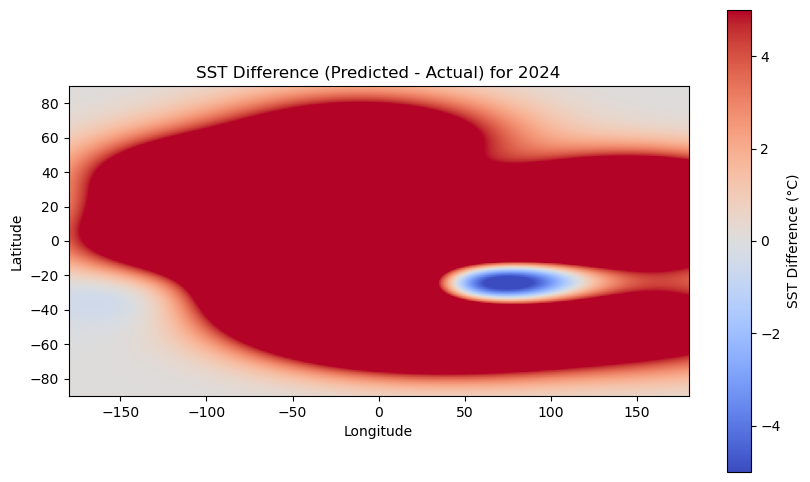

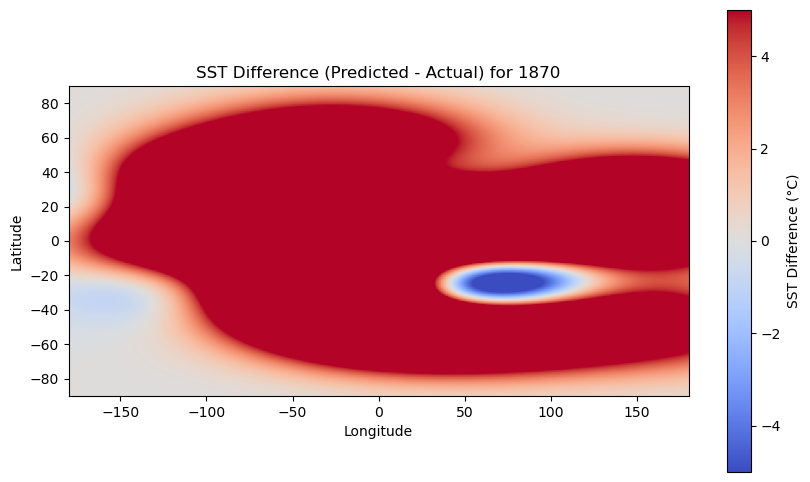

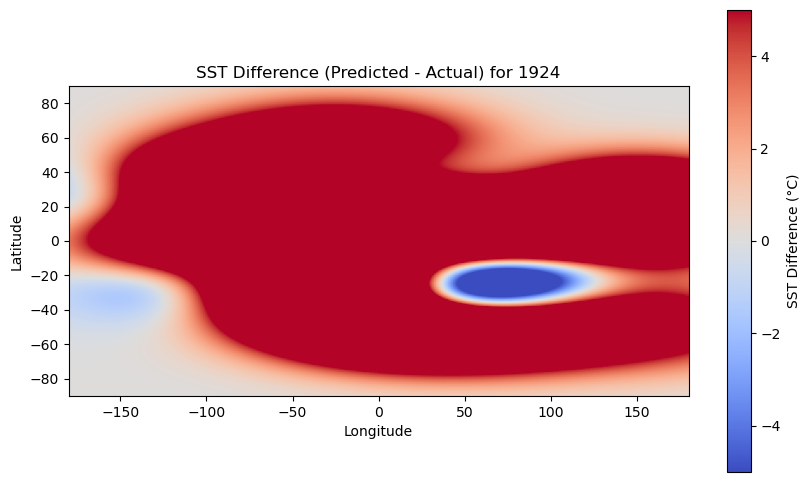

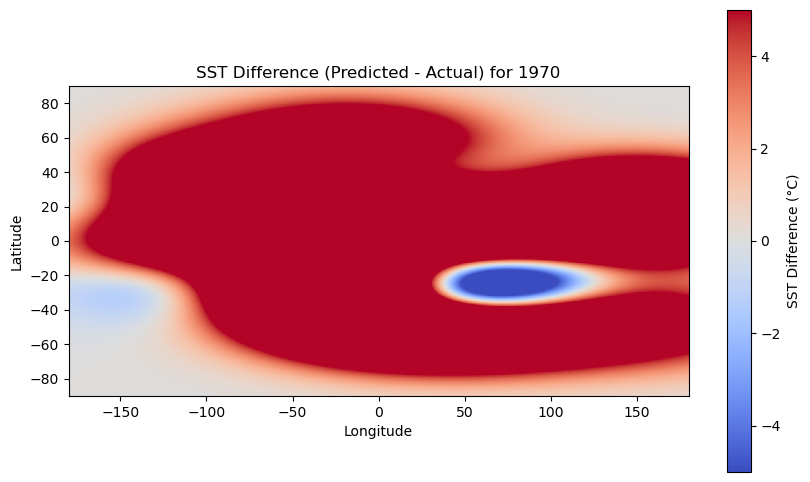

In [ ]:
#################################
# 3. PLOTTING: GLOBAL GPR PREDICTION MAPS FOR SELECTED YEARS
#################################

# Select years for which you want to visualize the differences.
years_to_plot = [2024, 1870, 1924, 1970]

for year in years_to_plot:
    # Extract the full global SST map for the selected year.
    df_year_global = HadISST_annual_ds.sst.sel(year=year).to_dataframe().reset_index()
    df_year_global['latitude']  = df_year_global['latitude'].round(1)
    df_year_global['longitude'] = df_year_global['longitude'].round(1)

    # Create the feature matrix for ALL grid points: [year, latitude, longitude]
    X_year_global = df_year_global[['year', 'latitude', 'longitude']].values
    X_year_global_scaled = scaler.transform(X_year_global)

    # Use the trained GPR model to predict SST over the entire global grid.
    sst_pred_global, sigma_global = gpr.predict(X_year_global_scaled, return_std=True)
    df_year_global['sst_pred'] = sst_pred_global

    # Compute the difference: (Predicted SST) minus (Actual SST)
    df_year_global['diff'] = df_year_global['sst_pred']
    #df_year_global['diff'] = df_year_global['sst_pred'] - df_year_global['sst']

    # Pivot the difference data into a 2D grid for plotting.
    diff_grid = df_year_global.pivot(index='latitude', columns='longitude', values='diff')

    # Plot the SST difference map.
    plt.figure(figsize=(10,6))
    im = plt.imshow(diff_grid.values,
                    origin='lower',
                    extent=[diff_grid.columns.min() - 0.5, diff_grid.columns.max() + 0.5,
                            diff_grid.index.min() - 0.5, diff_grid.index.max() + 0.5],
                    cmap='coolwarm',
                    vmin=-5, vmax=5)  # Adjust vmin and vmax as needed
    plt.title(f"SST Difference (Predicted - Actual) for {year}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(im, label='SST Difference (°C)')
    plt.show()

### Wrong Codes

In [ ]:
# GPR with core sites split into 70 + 16 for testing sites withholding (wrong method)

#################################
# 1. DATA PREPARATION
#################################

# Load the netCDF dataset and pre-process
HadISST = xr.open_dataset('HadISST_sst.nc')
# Clamp SST values: keep only values > -10 (others become NaN)
HadISST = HadISST.where(HadISST.sst > -10)
# Remove the last time layer (i.e. January 2025)
HadISST = HadISST.isel(time=slice(0, -1))
print("Time range:", HadISST.time.min().values, "to", HadISST.time.max().values)

# Compute annual averages (from monthly data) and convert to a Dataset with variable name "sst"
HadISST_annual = HadISST.sst.groupby('time.year').mean('time', skipna=True)
HadISST_annual_ds = HadISST_annual.to_dataset(name='sst')
print(HadISST_annual_ds)

# Convert the full annual dataset to a DataFrame.
# This DataFrame will have columns: year, latitude, longitude, and sst.
df_global = HadISST_annual_ds.sst.to_dataframe().reset_index()

# For merging purposes, round the coordinate values to one decimal.
df_global['latitude']  = df_global['latitude'].round(1)
df_global['longitude'] = df_global['longitude'].round(1)

# ------------------------------
# Use df_coords_round (the fixed set of 86 grid points)
# ------------------------------
# Ensure df_coords_round uses lowercase column names and round their coordinates
df_coords_round = df_coords_round.rename(columns={'Latitude': 'latitude', 'Longitude': 'longitude'})
df_coords_round['latitude']  = df_coords_round['latitude'].round(1)
df_coords_round['longitude'] = df_coords_round['longitude'].round(1)

# Before splitting, remove grid points that are land (NaN in sst) or sea ice (sst <= -1.8)
# (These values are not useful in the training process.)
df_global = df_global[df_global['sst'] > -1.8]

# Merge the global dataset with df_coords_round so that we only work with our 86 fixed grid points.
df_subset = pd.merge(df_global, df_coords_round, on=['latitude', 'longitude'], how='inner')
print("After merging with df_coords_round, total grid points =", df_subset.shape[0])

#################################
# 2. SPATIAL TRAINING/TEST SPLIT AND MODEL TRAINING
#################################

# (a) Create a spatial training/test split using the 86 grid points
# Randomly split these 86 coordinates into 70 training and 16 testing.
df_training_coords = df_coords_round.sample(n=70, random_state=42)
df_testing_coords  = df_coords_round.drop(df_training_coords.index)

# Now, merge these training and testing coordinates with df_global (over all years)
# so that we get training data (70 grid points for each year) and testing data (16 grid points for each year).
train_df = pd.merge(df_global, df_training_coords, on=['latitude', 'longitude'], how='inner')
test_df  = pd.merge(df_global, df_testing_coords, on=['latitude', 'longitude'], how='inner')

print("Total training samples (all years):", train_df.shape[0])
print("Total testing samples (all years):", test_df.shape[0])
if train_df.shape[0] == 0:
    raise ValueError("Training dataset is empty! Check the merge and filtering steps.")

# Prepare features and target.
# Features: year, latitude, longitude; Target: sst.
X_train = train_df[['year', 'latitude', 'longitude']].values
y_train = train_df['sst'].values
X_test  = test_df[['year', 'latitude', 'longitude']].values
y_test  = test_df['sst'].values

# Standardize the features.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Define and train a Gaussian Process Regression model.
kernel = (C(1.0, (1e-2, 1e2)) *
          RBF(length_scale=[1, 1, 1], length_scale_bounds=(1e-2, 1e2)) +
          WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1)))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr.fit(X_train_scaled, y_train)
print("Optimized kernel:", gpr.kernel_)

# Evaluate performance on the spatial test set (the withheld grid points over all years).
y_pred, sigma = gpr.predict(X_test_scaled, return_std=True)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Spatial leave-out Test RMSE: {rmse:.3f} °C")

years_to_plot = [2024, 1870, 1924, 1970]

for year in years_to_plot:
    # For a given year, extract the full global grid.
    df_year_global = HadISST_annual_ds.sst.sel(year=year).to_dataframe().reset_index()
    df_year_global['latitude']  = df_year_global['latitude'].round(1)
    df_year_global['longitude'] = df_year_global['longitude'].round(1)

    # Create the feature matrix (year, latitude, longitude) for every grid point.
    X_year_global = df_year_global[['year', 'latitude', 'longitude']].values
    X_year_global_scaled = scaler.transform(X_year_global)

    sst_pred_global, sigma_global = gpr.predict(X_year_global_scaled, return_std=True)
    df_year_global['sst_pred'] = sst_pred_global

    df_year_global['diff'] = df_year_global['sst_pred'] - df_year_global['sst']

    diff_grid = df_year_global.pivot(index='latitude', columns='longitude', values='diff')

    plt.figure(figsize=(10,6))
    im = plt.imshow(diff_grid.values,
                    origin='lower',
                    extent=[diff_grid.columns.min()-0.5, diff_grid.columns.max()+0.5,
                            diff_grid.index.min()-0.5, diff_grid.index.max()+0.5],
                    cmap='coolwarm',
                    vmin=-5, vmax=5)
    plt.title(f"SST Difference (Predicted - Actual) for {year}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(im, label='SST Difference (°C)')
    plt.show()

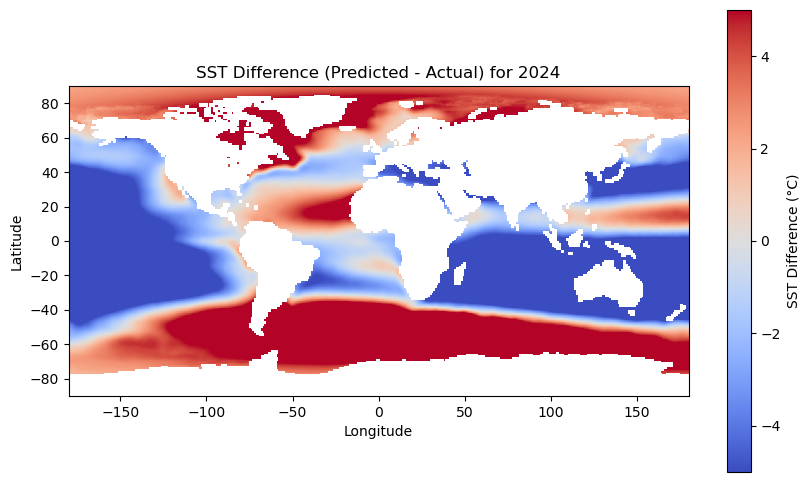

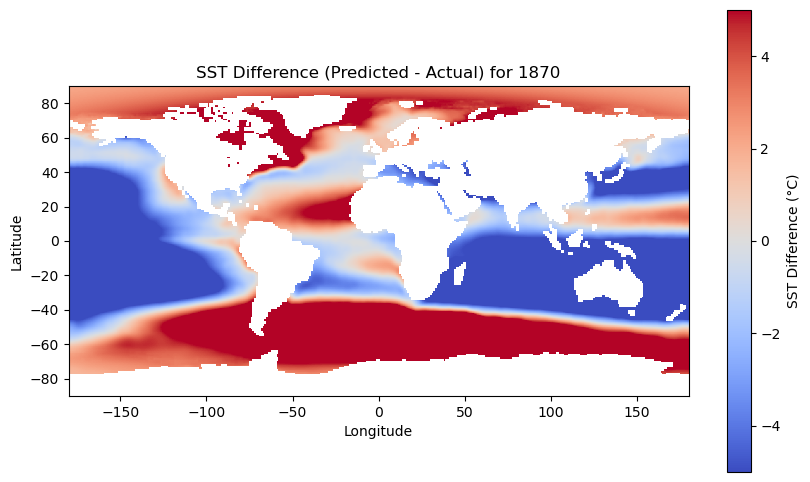

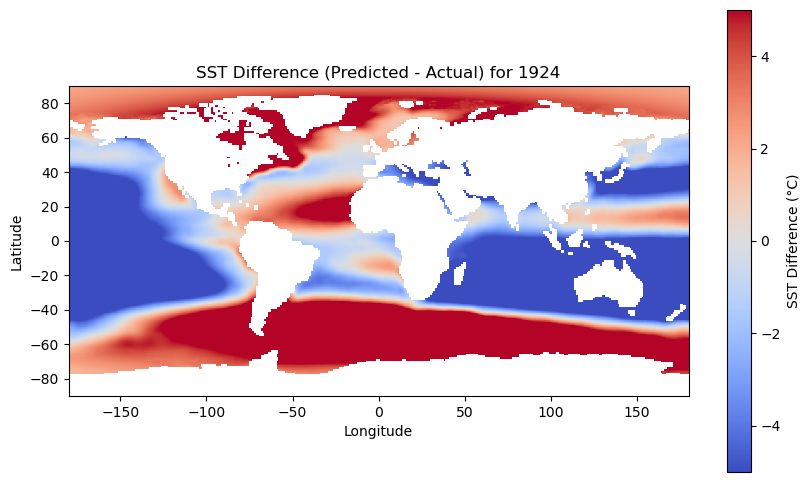

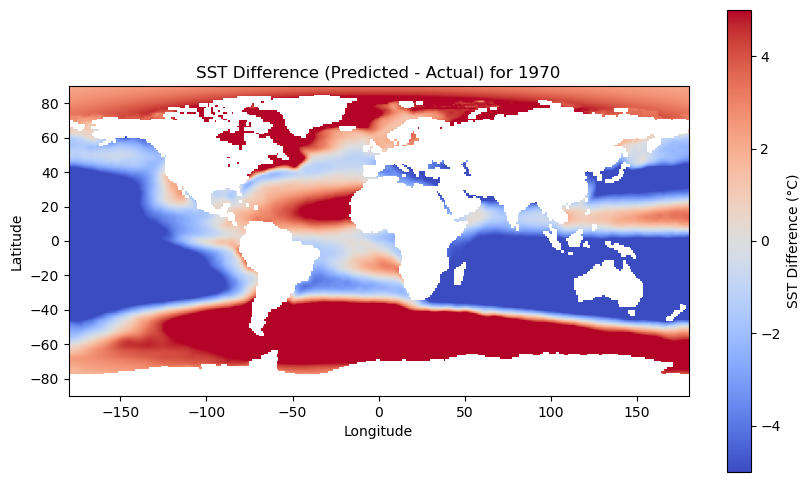

## Data Interpolation using Machine Learning 02/27

In [ ]:
# Read SST data at depth = 0m for each decadal average from World Ocean Atlas 2023
# https://www.ncei.noaa.gov/access/world-ocean-atlas-2023/bin/woa23.pl
df1 = pd.read_csv('woa_1955.csv')
df2 = pd.read_csv('woa_1965.csv')
df3 = pd.read_csv('woa_1975.csv')
df4 = pd.read_csv('woa_1985.csv')
df5 = pd.read_csv('woa_1995.csv')
df6 = pd.read_csv('woa_2005.csv')

# Create training data for Random Forest Model
training_data = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)
X = training_data[['Latitude', 'Longitude']]
y = training_data['SST']

### Create Random Forest Model

In [ ]:
# Create Random Forest Model

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the training data for validation (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Validate the model
y_pred = rf_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f"Validation MSE: {mse}")
rmse = np.sqrt(mse)
print(f"This indicates that, on average, the model's predictions deviate from the true SST values by about {rmse} ºC")

Validation MSE: 0.08366852763535988
Root Mean Squared Error: 0.2892551255126863 ºC.
This indicates that, on average, the model's predictions deviate from the true SST values by about 0.2892551255126863 ºC


### Map Random Forest ML Predicted SST from 1955-2014

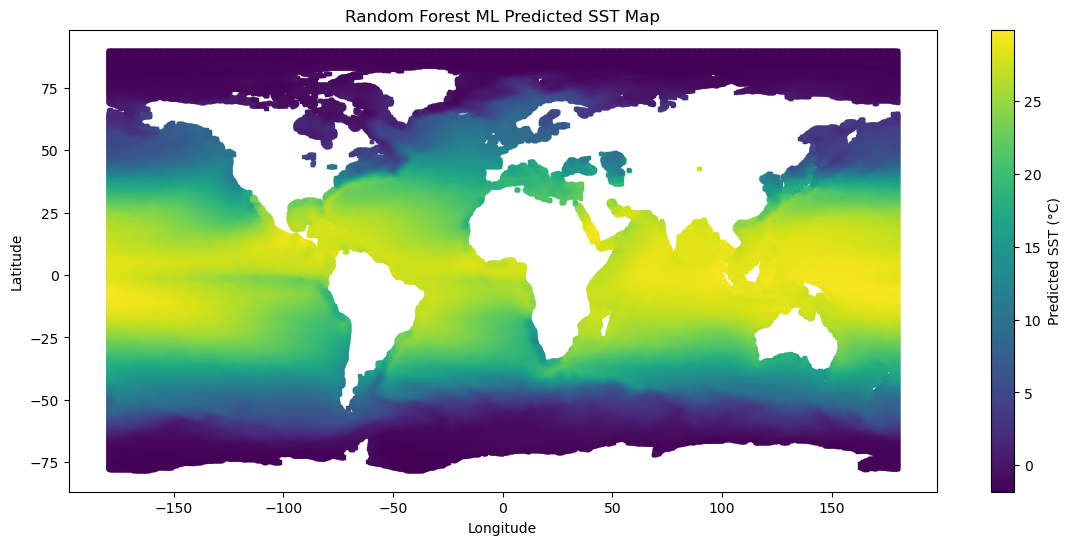

In [ ]:
# Map Random Forest ML Predicted SST from 1955-2014

# df1 is WOA 1955-1964 Decadal Average.
grid_df = df1.copy()

# Predict SST using the trained rf_model.
grid_df['Predicted_SST'] = rf_model.predict(grid_df[['Latitude', 'Longitude']])

# Plot using a scatter plot.
plt.figure(figsize=(14, 6))
sc = plt.scatter(grid_df['Longitude'], grid_df['Latitude'],
                 c=grid_df['Predicted_SST'], cmap='viridis', marker='s', s=5)
plt.colorbar(sc, label='Predicted SST (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Random Forest ML Predicted SST Map')
plt.show()

### Interpolate Paleo Data Using Random Forest Model on 1ºx1º NATL Grid

In [ ]:
# Interpolate Paleo Data Using Random Forest Model on 1ºx1º NATL Grid

# --- Step 1: Define the grid ---
# Bounding box as defined:
lat_min, lat_max = 35, 60
lon_min, lon_max = -50, -10

# Create grid boundaries with 1º resolution.
lat_edges = np.arange(lat_min, lat_max + 1, 1)
lon_edges = np.arange(lon_min, lon_max + 1, 1)

# Define grid cell centers for predictions (midpoints of each bin).
lat_centers = lat_edges[:-1] + 0.5
lon_centers = lon_edges[:-1] + 0.5
grid_lon, grid_lat = np.meshgrid(lon_centers, lat_centers)

In [ ]:
# --- Step 2: Predict SST on the grid using rf_model ---
# Create a DataFrame of all grid cell centers.
grid_df = pd.DataFrame({
    'Latitude': grid_lat.ravel(),
    'Longitude': grid_lon.ravel()
})

# Use the trained RandomForest model to predict SST.
grid_df['Predicted_SST'] = rf_model.predict(grid_df[['Latitude', 'Longitude']])

# Reshape predictions back into grid form.
predicted_SST_grid = grid_df['Predicted_SST'].values.reshape(grid_lat.shape)

In [ ]:
# --- Step 3: Aggregate paleo SST values (from gdf) into grid cells ---
# Assuming gdf contains columns: 'Latitude', 'Longitude', and 'SST'.
gdf = gdf.copy()  # work on a copy

# Create bins that match the grid edges.
gdf['lat_bin'] = pd.cut(gdf['Latitude'], bins=lat_edges, include_lowest=True)
gdf['lon_bin'] = pd.cut(gdf['Longitude'], bins=lon_edges, include_lowest=True)

# Group by grid cell and average the paleo SST values.
paleo_grid = gdf.groupby(['lat_bin', 'lon_bin'])['SST'].mean().reset_index()

# Calculate the midpoint of each bin to represent the cell center.
paleo_grid['lat_mid'] = paleo_grid['lat_bin'].apply(lambda x: x.mid)
paleo_grid['lon_mid'] = paleo_grid['lon_bin'].apply(lambda x: x.mid)

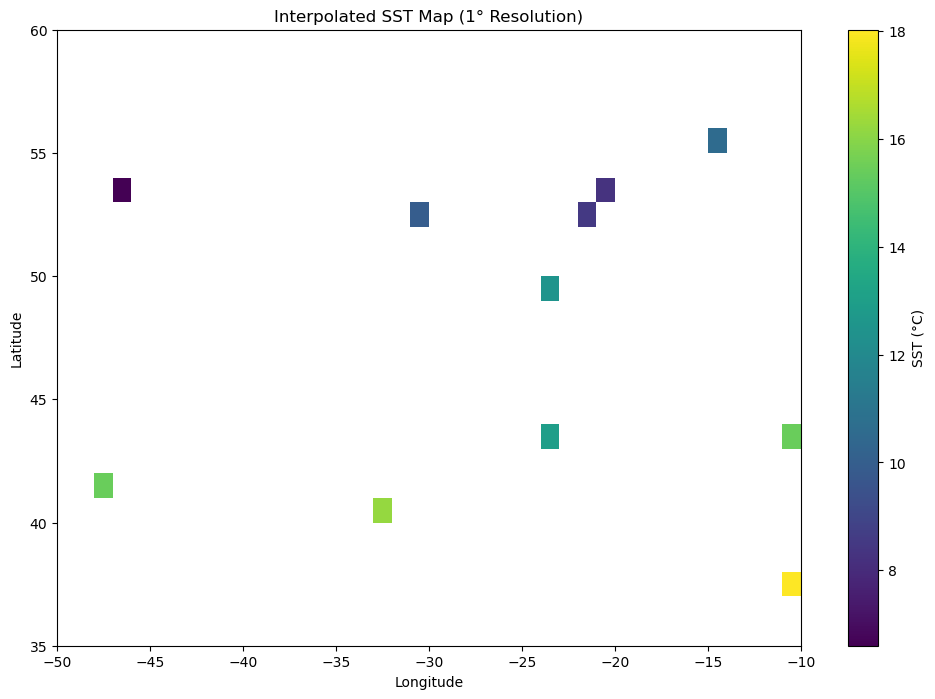

In [ ]:
# --- Step 4: Replace predictions with paleo observations where available ---
# Create a copy of the predicted grid to form the final SST field.
final_SST_grid = predicted_SST_grid.copy()

# For each paleo grid cell with observed data, update the corresponding grid cell.
for idx, row in paleo_grid.iterrows():
    # Find the index in lat_centers and lon_centers closest to the bin midpoint.
    lat_idx = np.abs(lat_centers - row['lat_mid']).argmin()
    lon_idx = np.abs(lon_centers - row['lon_mid']).argmin()
    # Replace the model prediction with the observed paleo SST.
    final_SST_grid[lat_idx, lon_idx] = row['SST']

# --- Step 5: Plot the final interpolated SST map ---
plt.figure(figsize=(14, 6))
plt.pcolormesh(lon_edges, lat_edges, final_SST_grid, cmap='viridis', shading='auto')
plt.colorbar(label='SST (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Interpolated SST Map (1° Resolution)')
plt.show()


## Data interpolation attempt 02/24 (IGNORE)

## Below is the old code used for Elli's Google Sheet
### Use the code above, ignore the code below